In [68]:
# ! pip3 install seaborn
# ! pip3 install python-dateutil
# ! nvidia-smi
# ! pip install torchviz
# ! pip3 install -U sentence-transformers
# ! pip3 install torchsummary
# ! pip3 install onnx
# ! pip3 install torchviz

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
import locale
import torch.nn.functional as F

%matplotlib inline

## Prep data

In [3]:
rfm_df = pd.read_csv("./data/fedsfm_20250125_102552.csv")
rfm_df

,ID,Порядковый номер,Имя,Дата рождения,Остальные данные,Террорист
0,c47f4216,1,"АБАДИЕВ МАГОМЕД МИКАИЛОВИЧ,",09.11.1982,", Г. НАЗРАНЬ ЧИАССР;",True
1,e36f040c,2,"АБАЕВ АСЛАНБЕК БАУДИНОВИЧ,",29.05.1983,", Г. ГРОЗНЫЙ ЧИАССР;",True
2,d1f64dca,3,"АБАЕВ ИДРИС МОВСАРОВИЧ,",02.01.1986,", С. СУВОРОВ-ЮРТ ГУДЕРМЕССКОГО РАЙОНА ЧИАССР;",True
3,4cc1b4c4,4,"АБАЕВ МУХАДИН ЮРЬЕВИЧ,",30.09.1981,", Г. НАЛЬЧИК КАБАРДИНО-БАЛКАРСКОЙ РЕСПУБЛИКИ;",True
4,688c1667,5,"АБАЗОВ АХМЕД ЭДУАРДОВИЧ,",30.08.1992,", С. КЫЗБУРУН-3 БАКСАНСКОГО РАЙОНА КАБАРДИНО-Б...",True
...,...,...,...,...,...,...
16414,c1381adf,16415,"ЯШУРКАЕВ ИСМАИЛ СУЛТАНОВИЧ,",21.05.1989,", С. СТАРАЯ СУНЖА ГРОЗНЕНСКОГО РАЙОНА ЧИАССР;",True
16415,172efb0d,16416,"ЯШУРКАЕВ УВАЙС ХАМЗАТОВИЧ,",22.03.1971,", С. ЧИРИ-ЮРТ ШАЛИНСКОГО РАЙОНА ЧИАССР;",True
16416,adf97aae,16417,"ЯЩУРКАЕВА МЕДНИ КИРИ-САИДОВНА,",27.11.1990,", С. СТАРЫЕ АТАГИ ГРОЗНЕНСКОГО РАЙОНА ЧЕЧЕНСКО...",True
16417,c59d7ddc,16418,"ЯЩУРКАЕВА ПЕТИМАТ АПТИЕВНА,",12.08.1990,", Г. ГРОЗНЫЙ ЧЕЧЕНСКОЙ РЕСПУБЛИКИ;",True


In [4]:
az_df = pd.read_csv("./data/Преследуемые-Grid View_allfields.csv")

In [5]:
az_df.columns

Index(['ФИО', 'Кейсы', '✦Дело', 'что известно о деле', 'Адрес для писем',
       '✦ Фамилия', '✦Имя', '✦Отчество',
       '✦Второе имя/имя на иностранном языке', '✦не/лишен/а свободы',
       '✦Списки/награды', '✦пол', '✦Дата рождения', 'День рождения',
       'Возраст на момент возб. дела', '✦Возраст',
       'возраст на момент возбуждения дела ИТОГ',
       'Возраст на момент возбуждения дела', '✦Дата смерти',
       '✦Фото преследуемого', '✦особые обст-ва', '✦Примечание',
       '✦Регион, где возбудили УД/задержали', '✦Город', 'Телефон', 'Email',
       'Соцсеть', 'Конт. лицо', '✦Группа поддержки',
       'Реквизиты для сбора средств', '✦Статус иноагента', '✦Росфинмониторинг',
       '✦Дата включения в список РФМ', '✦Дата исключения из списка РФМ',
       '✦published', '✦интересы для писем', 'Атаки', '✦Дата задержания',
       '✦Статья для ЕНБВ', '✦Тексты сгруппированные для сайта ЕНБВ',
       'Категория дела', 'Статус в деле', 'Форма преследования', 'Статья',
       'Приговор', 'Д

In [6]:
pd.unique(az_df["✦Росфинмониторинг"])

array([nan, 'checked'], dtype=object)

In [7]:
az_data_in_rfm = az_df[az_df["✦Росфинмониторинг"] == 'checked']

In [8]:
az_data_in_rfm["✦Дата рождения"]

452                    NaN
474     8 Сентября 1986 г.
480        31 Июля 1988 г.
482     23 Февраля 1989 г.
483        19 Июня 1981 г.
               ...        
7988       25 Июля 1976 г.
7993       22 Июня 2008 г.
7994    11 Августа 1978 г.
7999       5 Марта 2008 г.
8009         1 Мая 1982 г.
Name: ✦Дата рождения, Length: 2148, dtype: object

In [9]:
az_data_in_rfm["✦ Фамилия"]

452     67-летний уроженец Дагестана
474                          Аббазов
480                      Абдрахманов
482                       Абдулвапов
483                      Абдулгазиев
                    ...             
7988                        Ярошенко
7993                       Ястребцов
7994                      Ясюкевичюс
7999                          Яценко
8009                         Яячиков
Name: ✦ Фамилия, Length: 2148, dtype: object

In [10]:
rfm_df["Дата рождения"]

0        09.11.1982
1        29.05.1983
2        02.01.1986
3        30.09.1981
4        30.08.1992
            ...    
16414    21.05.1989
16415    22.03.1971
16416    27.11.1990
16417    12.08.1990
16418    01.05.1982
Name: Дата рождения, Length: 16419, dtype: object

In [11]:
def date_converter(date_str):
    # date_str = '3 Июля 1998 г.'
    months = {
        "Января": "January", "Февраля": "February", "Марта": "March",
        "Апреля": "April", "Мая": "May", "Июня": "June",
        "Июля": "July", "Августа": "August", "Сентября": "September",
        "Октября": "October", "Ноября": "November", "Декабря": "December"
    }
    for ru, en in months.items():
        date_str = date_str.replace(ru, en)
    parsed_date = datetime.strptime(date_str, "%d %B %Y г.")
    formatted_date = parsed_date.strftime("%d.%m.%Y")
    return formatted_date


def full_name_to_family_name(full_name):
    return full_name.split(" ")[0].lower()

In [12]:
# [date_converter(str(d)) for d in az_data_in_rfm["✦Дата рождения"]]
az_data_in_rfm["Date of birth"] = az_data_in_rfm["✦Дата рождения"].apply(lambda x: date_converter(x) if not pd.isna(x) else x)

/tmp/ipykernel_4073/3836504559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_data_in_rfm["Date of birth"] = az_data_in_rfm["✦Дата рождения"].apply(lambda x: date_converter(x) if not pd.isna(x) else x)


In [13]:
az_data_in_rfm["family_name"] =  az_data_in_rfm["✦ Фамилия"].apply(lambda x: full_name_to_family_name(x) if not pd.isna(x) else x)

/tmp/ipykernel_4073/351291044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_data_in_rfm["family_name"] =  az_data_in_rfm["✦ Фамилия"].apply(lambda x: full_name_to_family_name(x) if not pd.isna(x) else x)


In [14]:
rfm_df["family_name"] = rfm_df["Имя"].apply(lambda x: full_name_to_family_name(x) if not pd.isna(x) else x)
rfm_df["Date of birth"] = rfm_df["Дата рождения"]

In [15]:
az_data_in_rfm

,ФИО,Кейсы,✦Дело,что известно о деле,Адрес для писем,✦ Фамилия,✦Имя,✦Отчество,✦Второе имя/имя на иностранном языке,✦не/лишен/а свободы,...,где находится,Суд в апелляции,Судья в апелляции,ссылка на карточку дела на сайте суда,Год рождения (обновлено),особые обстоятельства Атаки,Статьи (стат.),Год возбуждения дела (from Кейсы),Date of birth,family_name
452,67-летний уроженец Дагестана,"""67-летний уроженец Дагестана, Дело о покушени...",Дело о покушение на сотрудничество с иностранн...,В Санкт-Петербурге в середине января 2024 года...,NaN,67-летний уроженец Дагестана,NaN,NaN,NaN,лишен/а свободы,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,NaN,67-летний
474,Аббазов Марс Масхутович,"""Аббазов Марс Масхутович, Дело о финансировани...",Дело о финансировании терроризма против имама ...,В Ульяновске 19 июня 2024 года силовики в сред...,"Аббазов Марс Масхутович, 8 сентября 1986 г.\nФ...",Аббазов,Марс,Масхутович,NaN,лишен/а свободы,...,ФКУ СИЗО-1 УФСИН России по Ульяновской области...,NaN,NaN,NaN,1986.0,NaN,NaN,2024,08.09.1986,аббазов
480,Абдрахманов Раиль Рафаилович,"""Абдрахманов Раиль Рафаилович, Казанское дело ...",Казанское дело 4 о членстве в запрещённой «Хиз...,Четверо жителейКазани осуждены за причастность...,"Абдрахманов Раиль Рафаилович, 31 июля 1988 г.\...",Абдрахманов,Раиль,Рафаилович,NaN,лишен/а свободы,...,"ФКУ Т ГУФСИН России по Челябинской области, ад...",Апелляционный военный суд,Егоров Олег Александрович,https://covs--svd.sudrf.ru/modules.php?name=su...,1988.0,NaN,NaN,NaN,31.07.1988,абдрахманов
482,Абдулвапов Аметхан Наджип-оглы,"""Абдулвапов Аметхан Наджип-оглы, Дело о причас...",Дело о причастности к организации «Хизб ут-Тах...,"Ростовский суд приговорил к 10,5 годам лишения...","Абдулвапов Аметхан Наджип-оглы, 23 февраля 198...",Абдулвапов,Аметхан,Наджип-оглы,NaN,лишен/а свободы,...,ФКУ СИЗО-1 ГУФСИН России по Ростовской области...,Апелляционный военный суд,Солин Анатолий Валентинович,https://yovs--ros.sudrf.ru/modules.php?name=su...,1989.0,NaN,NaN,2022,23.02.1989,абдулвапов
483,Абдулгазиев Тофик Султанович,"""Абдулгазиев Тофик Султанович, Симферопольское...",Симферопольское дело 25 о членстве в запрещённ...,27 марта 2019 года в Крыму проходили самые мас...,"Абдулгазиев Тофик Султанович, 19 июня 1981 г.\...",Абдулгазиев,Тофик,Султанович,NaN,лишен/а свободы,...,"ФКУ Т ГУФСИН России по Челябинской области, ад...",Апелляционный военный суд,Солин Анатолий Валентинович,https://yovs--ros.sudrf.ru/modules.php?name=su...,1981.0,NaN,NaN,NaN,19.06.1981,абдулгазиев
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7988,Ярошенко Юрий Борисович,"""Ярошенко Юрий Борисович, Подготовка отравлени...",Подготовка отравления и взрыва военнослужащих ...,В Белгороде в марте 2024 года задержали 47-лет...,"Ярошенко Юрий Борисович, 25 июля 1976 г.\nФКУ ...",Ярошенко,Юрий,Борисович,NaN,лишен/а свободы,...,ФКУ СИЗО-3 УФСИН России по Белгородской област...,NaN,NaN,NaN,1976.0,NaN,NaN,2024,25.07.1976,ярошенко
7993,Ястребцов Юсуф Дмитриевич,"""Ястребцов Юсуф Дмитриевич, Дело против несове...",Дело против несовершеннолетних Юсуфа Ястребцов...,В Тобольске Тюменской области 9 августа 2024 г...,"Ястребцов Юсуф Дмитриевич, 22 июня 2008 г.\nФК...",Ястребцов,Юсуф,Дмитриевич,NaN,лишен/а свободы,...,"ФКУ СИЗО-1 УФСИН России по Тюменской области, ...",NaN,NaN,NaN,2008.0,NaN,NaN,2024,22.06.2008,ястребцов
7994,Ясюкевичюс Шарунас,"""Ясюкевичюс Шарунас, Дело против военнослужаще...",Дело против военнослужащего ВСУ Шарунаса Ясюке...,В Курской области в ноябре 2024 года против гр...,NaN,Ясюкевичюс,Шарунас,NaN,NaN,не лишен/а свободы,...,NaN,NaN,NaN,NaN,1978.0,NaN,NaN,2024,11.08.1978,ясюкевичюс
7999,Яценко Юрий Алексеевич,"""Яценко Юрий Алексеевич, Покушение на теракт в...",Покушение на теракт в Липецке против Юрия Яценко,17 июля 2024 ОРП ОП №8 СУ УМВД России по г. Ли...,"Яценко Юрий Алексеевич, 5 марта 2008 г.\nФКУ С...",Яценко,Юрий,Алексеевич,NaN,лишен/а свободы,...,"ФКУ СИЗО-5 УФСИН России по г. Москве, адрес: 1...",NaN,NaN,NaN,200

In [16]:
common_DoBs = set(rfm_df["Дата рождения"]).intersection(set(az_data_in_rfm["Date of birth"]))

In [17]:
len(common_DoBs)

1943

In [18]:
rfm_df_filtered = rfm_df[rfm_df["Дата рождения"].isin(common_DoBs)]
az_data_filtered = az_data_in_rfm[az_data_in_rfm["Date of birth"].isin(common_DoBs)]

In [19]:
a = {"a": '123', "b": 'c'}
' '.join(a.values())

'123 c'

In [20]:
az_data_filtered['az_row_as_json'] = az_data_filtered.apply(lambda row: ' '.join([str(v) for v in row.to_dict().values()]), axis=1)
az_data_filtered.shape

/tmp/ipykernel_4073/1885313564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  az_data_filtered['az_row_as_json'] = az_data_filtered.apply(lambda row: ' '.join([str(v) for v in row.to_dict().values()]), axis=1)


(2077, 80)

In [21]:
rfm_df_filtered['frm_row_as_json'] = rfm_df_filtered.apply(lambda row: ' '.join([str(v) for v in row.to_dict().values()]), axis=1)

# Perform an inner join on 'common_id'

# Keep only the JSON columns from both DataFrames if needed
# result = merged_df[['common_id', 'row_as_json_az_data', 'row_as_json_rfm']]
rfm_df_filtered.shape

/tmp/ipykernel_4073/950852458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_filtered['frm_row_as_json'] = rfm_df_filtered.apply(lambda row: ' '.join([str(v) for v in row.to_dict().values()]), axis=1)


(3916, 9)

In [22]:
# merged_df = pd.merge(az_data_filtered, rfm_df_filtered, on=['Date of birth', 'family_name'], how='inner')
merged_df = pd.merge(az_data_filtered, rfm_df_filtered, on=['Date of birth', 'family_name'], how='inner')
merged_df.shape

(1914, 87)

In [23]:
result = merged_df[['az_row_as_json', 'frm_row_as_json']]

In [24]:
result

,az_row_as_json,frm_row_as_json
0,"Аббазов Марс Масхутович ""Аббазов Марс Масхутов...","b86a6ca1 48 АББАЗОВ МАРС МАСХУТОВИЧ, 08.09.198..."
1,"Абдрахманов Раиль Рафаилович ""Абдрахманов Раил...","a9446e63 68 АБДРАХМАНОВ РАИЛЬ РАФАИЛОВИЧ, 31.0..."
2,"Абдулвапов Аметхан Наджип-оглы ""Абдулвапов Аме...","6b23d2df 148 АБДУЛВАПОВ АМЕТХАН НАДЖИП-ОГЪЛЫ, ..."
3,"Абдулгазиев Тофик Султанович ""Абдулгазиев Тофи...","694832e6 153 АБДУЛГАЗИЕВ ТОФИК СУЛТАНОВИЧ, 19...."
4,"Абдулин Тимур Эдуардович ""Абдулин Тимур Эдуард...","d328a0f2 171 АБДУЛИН ТИМУР ЭДУАРДОВИЧ, 22.05.2..."
...,...,...
1909,"Ярошенко Юрий Борисович ""Ярошенко Юрий Борисов...","2c7fa4ff 16367 ЯРОШЕНКО ЮРИЙ БОРИСОВИЧ, 25.07...."
1910,"Ястребцов Юсуф Дмитриевич ""Ястребцов Юсуф Дмит...","d903a4f5 16379 ЯСТРЕБЦОВ ЮСУФ ДМИТРИЕВИЧ, 22.0..."
1911,"Ясюкевичюс Шарунас ""Ясюкевичюс Шарунас, Дело п...","884374cc 16383 ЯСЮКЕВИЧЮС ШАРУНАС, 11.08.1978 ..."
1912,"Яценко Юрий Алексеевич ""Яценко Юрий Алексеевич...","da9b7e96 16408 ЯЦЕНКО ЮРИЙ АЛЕКСЕЕВИЧ, 05.03.2..."


## Embeddings

In [25]:
# from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

/home/yulia/1dev/devenv3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
# sentences = ['Привет! Как твои дела?',
#              'А правда, что 42 твое любимое число?']

#Load AutoModel from huggingface model repository
print("loading tokenizer")
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
print("loading bert")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru").to("cuda")


def make_embeddings(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
    encoded_input = encoded_input.to("cuda")
    
    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    #Perform pooling. In this case, mean pooling
    emb = mean_pooling(model_output, encoded_input['attention_mask'])
    emb = F.normalize(emb, p=2, dim=1)
    return emb

loading tokenizer
loading bert


/home/yulia/1dev/devenv3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yulia/1dev/devenv3.10/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [27]:
# result['az_row_as_json']

In [28]:
embeddings_az = make_embeddings(result['az_row_as_json'].to_list())
embeddings_frm = make_embeddings(result['frm_row_as_json'].to_list())
# print(embeddings_az.shape, embeddings_frm.shape)

In [29]:
similarities = torch.mm(embeddings_az, embeddings_frm.T).to("cpu")

In [30]:
similarities.shape

torch.Size([1914, 1914])

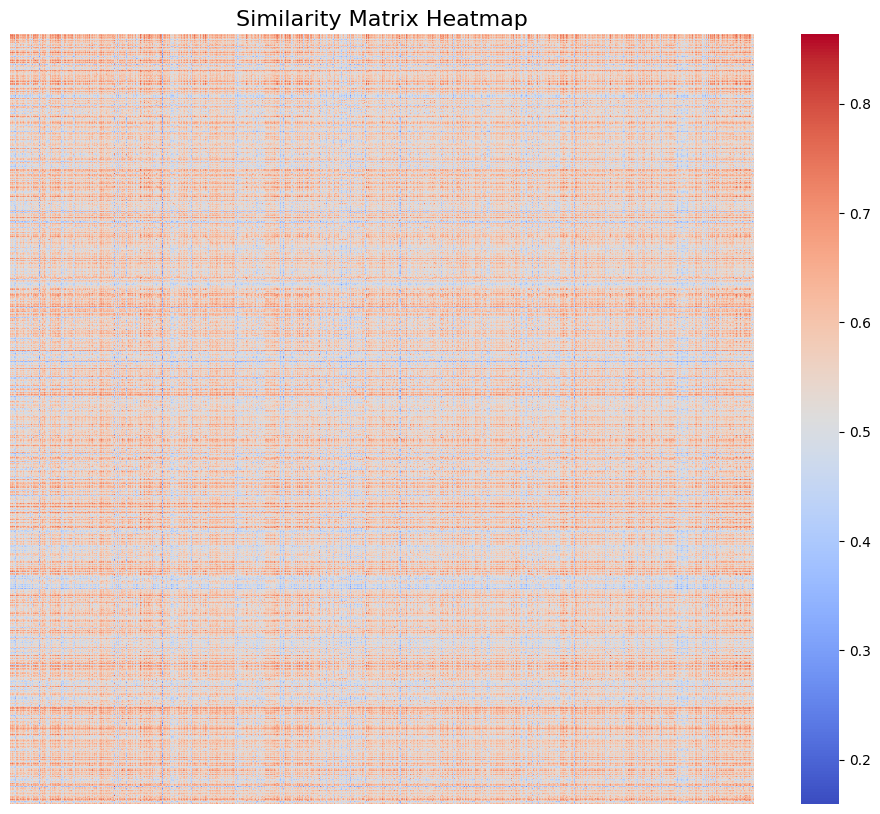

In [31]:
plt.figure(figsize=(12, 10))
sns.heatmap(similarities, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)

plt.title("Similarity Matrix Heatmap", fontsize=16)
plt.show()

## Something more complex

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
pos_pairs = []

for i in range(embeddings_frm.shape[0]):
    pos_pairs.append([(embeddings_frm[i], embeddings_az[i]), 1.0])

neg_pairs = []

for _ in range(9):
    for i in range(embeddings_frm.shape[0]):
        neg_pairs.append([(embeddings_frm[i], random.choice(embeddings_az)), 0.0])

In [35]:
full_dataset = neg_pairs + pos_pairs
random.shuffle(full_dataset)

## Dataset

In [36]:
class PairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        emb_a, emb_b = self.pairs[idx]
        label = self.labels[idx]
        return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for emb_a, emb_b, labels in train_loader:
            # Move data to GPU if available
            emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(emb_a, emb_b).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for emb_a, emb_b, labels in val_loader:
                emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.to(device)
                outputs = model(emb_a, emb_b).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

## FCCM

In [37]:
class FullyConnectedComparisonModel(nn.Module):
    def __init__(self, embedding_dim):
        super(FullyConnectedComparisonModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),  # Concatenate + Element-wise difference + Element-wise product
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, emb_a, emb_b):
        emb_a = F.normalize(emb_a, p=2, dim=1)
        emb_b = F.normalize(emb_b, p=2, dim=1)
        # (F.normalize(torch.tensor(a), p=2, dim=0)
        # Compute additional features: element-wise difference and product
        elementwise_diff = torch.abs(emb_a - emb_b)
        elementwise_prod = emb_a * emb_b

        # Concatenate original embeddings with difference and product
        combined = torch.cat((emb_a, emb_b, elementwise_diff, elementwise_prod), dim=1)

        # Pass through the fully connected layers
        output = self.fc(combined)
        return output

In [38]:
labels = [d[1] for d in full_dataset]
pairs = [d[0] for d in full_dataset]

dataset = PairDataset(pairs, labels)
embedding_size = pairs[0][0].shape[0]

train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
fcc_model = FullyConnectedComparisonModel(embedding_dim=embedding_size)
fcc_model.apply(initialize_weights)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(fcc_model.parameters(), lr=0.0001)

# Train the Model
train_model(fcc_model, train_loader, val_loader, criterion, optimizer, num_epochs=200)

/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Epoch 1/200, Loss: 0.3784, Val Loss: 0.3147
Epoch 2/200, Loss: 0.3243, Val Loss: 0.3126
Epoch 3/200, Loss: 0.3208, Val Loss: 0.3097
Epoch 4/200, Loss: 0.3159, Val Loss: 0.3061
Epoch 5/200, Loss: 0.3100, Val Loss: 0.3010
Epoch 6/200, Loss: 0.3040, Val Loss: 0.2958
Epoch 7/200, Loss: 0.2960, Val Loss: 0.2873
Epoch 8/200, Loss: 0.2866, Val Loss: 0.2782
Epoch 9/200, Loss: 0.2744, Val Loss: 0.2645
Epoch 10/200, Loss: 0.2591, Val Loss: 0.2511
Epoch 11/200, Loss: 0.2432, Val Loss: 0.2380
Epoch 12/200, Loss: 0.2274, Val Loss: 0.2239
Epoch 13/200, Loss: 0.2139, Val Loss: 0.2131
Epoch 14/200, Loss: 0.2021, Val Loss: 0.2042
Epoch 15/200, Loss: 0.1915, Val Loss: 0.1955
Epoch 16/200, Loss: 0.1847, Val Loss: 0.1922
Epoch 17/200, Loss: 0.1755, Val Loss: 0.1856
Epoch 18/200, Loss: 0.1690, Val Loss: 0.1796
Epoch 19/200, Loss: 0.1644, Val Loss: 0.1763
Epoch 20/200, Loss: 0.1581, Val Loss: 0.1710
Epoch 21/200, Loss: 0.1541, Val Loss: 0.1686
Epoch 22/200, Loss: 0.1497, Val Loss: 0.1647
Epoch 23/200, Loss:

In [39]:
# del model, optimizer
# del train_loader, val_loader
# torch.cuda.empty_cache()

## Eval

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [65]:
def evaluate_model(model, dataloader, threshold, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the appropriate device

    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for emb_a, emb_b, labels in dataloader:
            emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.to(device)
            outputs = model(emb_a, emb_b).squeeze(1)  # Get predictions
            predictions = (outputs > threshold).float()  # Apply threshold to get binary predictions
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, pos_label=1)
    recall = recall_score(all_labels, all_predictions, pos_label=1)
    f1 = f1_score(all_labels, all_predictions, pos_label=1)

    # Calculate metrics for the negative class (label = 0)
    precision_neg = precision_score(all_labels, all_predictions, pos_label=0)
    recall_neg = recall_score(all_labels, all_predictions, pos_label=0)
    f1_neg = f1_score(all_labels, all_predictions, pos_label=0)

    # Print scores
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Positive Class - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"Negative Class - Precision: {precision_neg:.4f}, Recall: {recall_neg:.4f}, F1-Score: {f1_neg:.4f}")

    return accuracy, {
        "positive": {"precision": precision, "recall": recall, "f1": f1},
        "negative": {"precision": precision_neg, "recall": recall_neg, "f1": f1_neg}
    }

def plot_confusion_matrix(model, dataloader, threshold, device, class_names=["Negative", "Positive"]):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the appropriate device

    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for emb_a, emb_b, labels in dataloader:
            emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.to(device)
            outputs = model(emb_a, emb_b).squeeze(1)  # Get predictions
            predictions = (outputs > threshold).float()  # Apply threshold to get binary predictions
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Normalize confusion matrix by row (relative values)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Normalized Confusion Matrix")
    plt.show()

def plot_abs_confusion_matrix(model, dataloader, threshold, device, class_names=["Negative", "Positive"]):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the appropriate device

    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for emb_a, emb_b, labels in dataloader:
            emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.to(device)
            outputs = model(emb_a, emb_b).squeeze(1)  # Get predictions
            predictions = (outputs > threshold).float()  # Apply threshold to get binary predictions
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Normalize confusion matrix by row (relative values)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    # sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Normalized Confusion Matrix")
    plt.show()

In [42]:
threshold = 0.667

result = evaluate_model(fcc_model, test_loader, threshold, "cuda")

Accuracy: 0.9619
Positive Class - Precision: 0.8313, Recall: 0.7541, F1-Score: 0.7908
Negative Class - Precision: 0.9743, Recall: 0.9838, F1-Score: 0.9790


/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


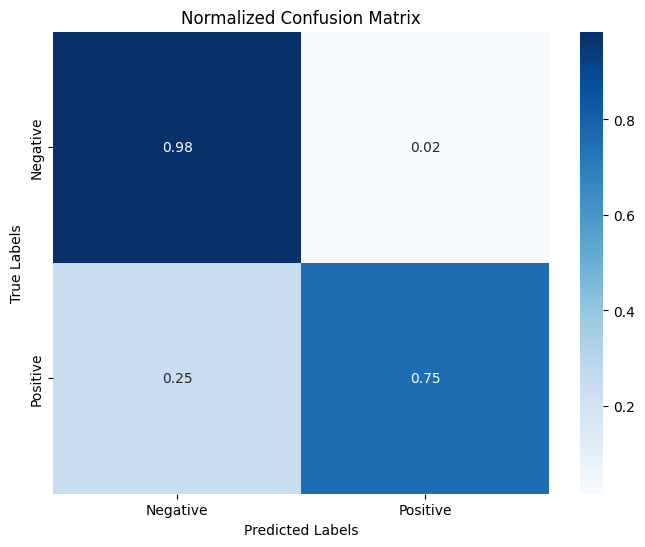

In [43]:
plot_confusion_matrix(fcc_model, test_loader, threshold, "cuda")

## TCM

In [53]:
class TransformerComparisonModel(nn.Module):
    def __init__(self, embedding_dim, num_heads=8, num_transformer_layers=2, hidden_dim=512):
        super(TransformerComparisonModel, self).__init__()
        
        # Transformer Encoder
        self.input_projection = nn.Linear(embedding_dim * 4, hidden_dim)  # Project combined embeddings
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim * 4, 
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 1),
            # nn.Sigmoid()  # Optional: Use BCEWithLogitsLoss and remove Sigmoid
        )
    
    def forward(self, emb_a, emb_b):
        # Normalize embeddings
        emb_a = F.normalize(emb_a, p=2, dim=1)
        emb_b = F.normalize(emb_b, p=2, dim=1)
        
        # Combine embeddings
        elementwise_diff = torch.abs(emb_a - emb_b)
        elementwise_prod = emb_a * emb_b
        combined_features = torch.cat((emb_a, emb_b, elementwise_diff, elementwise_prod), dim=1)
        
        # Project to hidden_dim for Transformer
        projected_features = self.input_projection(combined_features).unsqueeze(1)  # Add sequence dimension
        
        # Transformer Encoder
        transformer_output = self.transformer(projected_features).squeeze(1)  # Remove sequence dimension
        
        # Fully Connected Layers
        output = self.fc(transformer_output)
        return output

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for emb_a, emb_b, labels in train_loader:
            emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(emb_a, emb_b).squeeze(1)
            
            # Debug outputs
            assert not torch.any(torch.isnan(outputs)), "Model outputs contain NaNs"
            assert not torch.any(torch.isinf(outputs)), "Model outputs contain Infs"
            
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for emb_a, emb_b, labels in val_loader:
                emb_a, emb_b, labels = emb_a.to(device), emb_b.to(device), labels.float().to(device)
                outputs = model(emb_a, emb_b).squeeze(1)
                val_loss += criterion(outputs, labels).item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


In [54]:
embedding_size = pairs[0][0].shape[0]
 
dataset = PairDataset(pairs, labels)

train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
tc_model = TransformerComparisonModel(embedding_dim=embedding_size)
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([100.], device="cuda")
)  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(tc_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the Model
train_model(tc_model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

/home/yulia/1dev/devenv3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Epoch 1/100, Loss: 3.2409, Val Loss: 3.1203
Epoch 2/100, Loss: 3.1743, Val Loss: 3.1177
Epoch 3/100, Loss: 3.1862, Val Loss: 3.1690
Epoch 4/100, Loss: 3.1792, Val Loss: 3.1222
Epoch 5/100, Loss: 3.1668, Val Loss: 3.1451
Epoch 6/100, Loss: 3.1793, Val Loss: 3.1238
Epoch 7/100, Loss: 3.1648, Val Loss: 3.1269
Epoch 8/100, Loss: 3.1516, Val Loss: 3.1409
Epoch 9/100, Loss: 3.1477, Val Loss: 3.1510
Epoch 10/100, Loss: 3.1831, Val Loss: 3.1508
Epoch 11/100, Loss: 3.1936, Val Loss: 3.1309
Epoch 12/100, Loss: 3.1574, Val Loss: 3.1352
Epoch 13/100, Loss: 3.1671, Val Loss: 3.1549
Epoch 14/100, Loss: 3.1558, Val Loss: 3.1244
Epoch 15/100, Loss: 3.1478, Val Loss: 3.1186
Epoch 16/100, Loss: 3.1390, Val Loss: 3.1188
Epoch 17/100, Loss: 3.1355, Val Loss: 3.1413
Epoch 18/100, Loss: 3.1366, Val Loss: 3.1203
Epoch 19/100, Loss: 3.1335, Val Loss: 3.1226
Epoch 20/100, Loss: 3.1402, Val Loss: 3.1250
Epoch 21/100, Loss: 3.1375, Val Loss: 3.1285
Epoch 22/100, Loss: 3.1376, Val Loss: 3.1437
Epoch 23/100, Loss:

Accuracy: 0.8866
Positive Class - Precision: 0.4656, Recall: 0.9215, F1-Score: 0.6186
Negative Class - Precision: 0.9902, Recall: 0.8828, F1-Score: 0.9334


/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


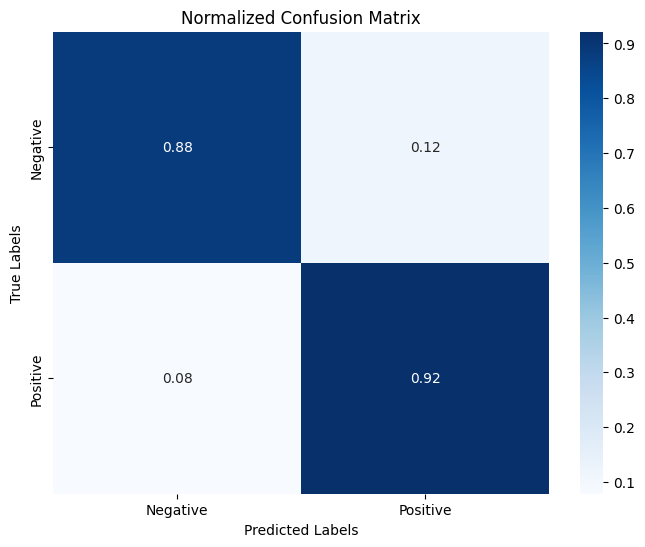

/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


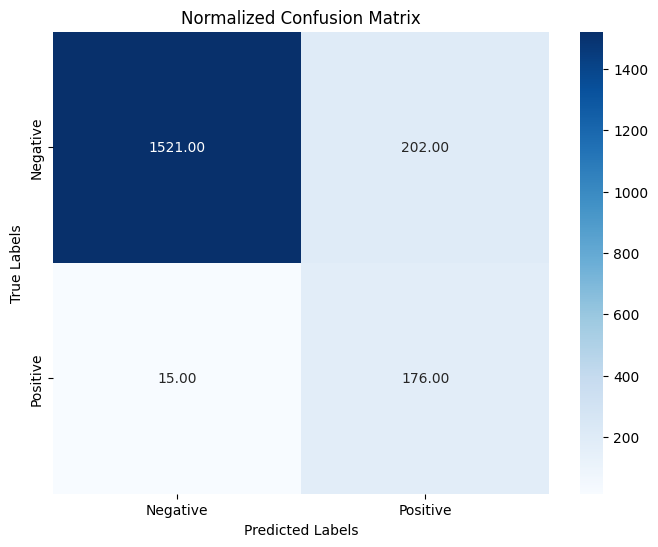

In [66]:
threshold = 0.95

evaluate_model(tc_model, test_loader, threshold, "cuda")
plot_confusion_matrix(tc_model, test_loader, threshold, "cuda")
plot_abs_confusion_matrix(tc_model, test_loader, threshold, "cuda")

## TCM vis

In [48]:
torch.onnx.export(
    tc_model, 
    (train_dataset[0][0].unsqueeze(0), train_dataset[0][1].unsqueeze(0)), 
    "model.onnx", 
    input_names=["AZ entry embedding", "new entry embedding"], 
    output_names=["is this entry"], 
    dynamic_axes={"AZ embedding": {0: "batch_size"}, "new entry embedding": {0: "batch_size"}}
)

/tmp/ipykernel_4073/513679339.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb_a, dtype=torch.float32), torch.tensor(emb_b, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
/home/yulia/1dev/devenv3.10/lib/python3.10/site-packages/torch/onnx/utils.py:1963: UserWarning: Provided key AZ embedding for dynamic axes is not a valid input/output name
  warnings.warn(


## Saving the result

In [70]:
torch.save(tc_model.state_dict(), "./fcc_model_v001.pth")